# EM casing response

In [74]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
from multiprocessing import Pool
import pickle

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import frequency_domain as fdem
from SimPEG.electromagnetics import resistivity as dc
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [2]:
path_to_data = "/t40array/lheagy/casing-permeability"

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [4]:
save_figures = True
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [5]:
run_simulations = True
directory = f"{path_to_data}/fields_permeability_fdem"

In [6]:
import os
if not os.path.exists(directory):
    os.makedirs(directory)

In [7]:
# conductivities
sigma_air = 1e-4
sigma_back = np.r_[1e-2, 1e-1, 1]
sigma_casing = 5e6
mur_casing = np.r_[1, 50, 100, 150, 200]

# casing geometry
casing_b = 5e-2  
casing_t = 10e-3
casing_a = casing_b - casing_t
casing_l = 500

In [8]:
# skin depth
503/np.sqrt(sigma_back)

array([5030.        , 1590.62566306,  503.        ])

In [9]:
return_electrode_r = 500
src_a = np.r_[casing_a+casing_t/2, 0, 0]
src_b = np.r_[return_electrode_r, 0., 0.]

In [10]:
csz = 5
nabove = 3
npadz = 18
pf = 1.4

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t/4., 
    npadx=13,
    csx2=25,
    domain_x=return_electrode_r,
    pfx2=pf
)

# Theta discretization
ny = 12
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

# vertical discretization
ncz = casing_l/csz
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz+nabove), (csz, npadz, pf)])

# create the mesh
mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz-nabove].sum()])
print(mesh.n_cells)

150120


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:247: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


In [11]:
frequencies = np.logspace(-1, 2, 19)  
frequencies = np.array([float(f"{f:1.1e}") for f in frequencies])
print(frequencies)
print(503/np.sqrt(sigma_back.min()*frequencies))
print(503/np.sqrt(sigma_casing*frequencies))

[  0.1    0.15   0.22   0.32   0.46   0.68   1.     1.5    2.2    3.2
   4.6    6.8   10.    15.    22.    32.    46.    68.   100.  ]
[15906.25663065 12987.40415428 10723.99603269  8891.86777342
  7416.33039459  6099.77096966  5030.          4106.97780207
  3391.22530819  2811.85548171  2345.24959272  1928.91694695
  1590.62566306  1298.74041543  1072.39960327   889.18677734
   741.63303946   609.97709697   503.        ]
[0.71134942 0.58081437 0.47959168 0.39765642 0.33166838 0.27279005
 0.22494844 0.18366963 0.15166021 0.12575    0.10488275 0.08626379
 0.07113494 0.05808144 0.04795917 0.03976564 0.03316684 0.02727901
 0.02249484]


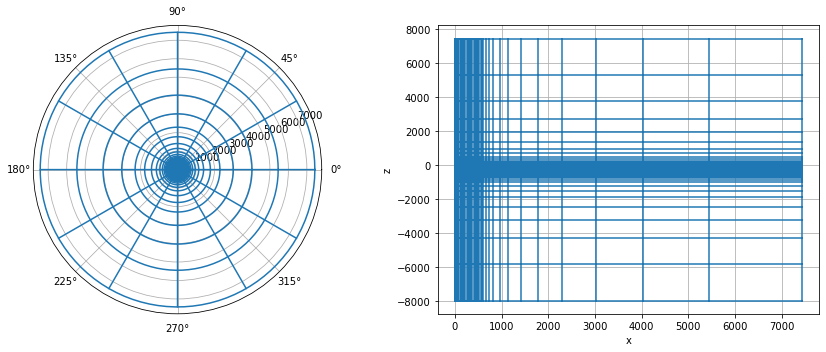

In [12]:
ax = mesh.plot_grid()

In [13]:
inds_casing_x = (
    (mesh.cell_centers[:, 0] > casing_a) & 
    (mesh.cell_centers[:, 0] < casing_b)
)
inds_casing_z = (
    (mesh.cell_centers[:, 2] < 0) &
    (mesh.cell_centers[:, 2] > -casing_l)
)
inds_casing = inds_casing_x & inds_casing_z

In [14]:
mur_casing

array([  1,  50, 100, 150, 200])

In [15]:
sigma_back

array([0.01, 0.1 , 1.  ])

In [16]:
models = {}
for sig in sigma_back: 
    halfspace_conductivity = sig * np.ones(mesh.n_cells)
    halfspace_conductivity[mesh.cell_centers[:, 2] > 0] = sigma_air

    casing_conductivity = halfspace_conductivity.copy()
    casing_conductivity[inds_casing] = sigma_casing

    models[f"halfspace_{sig:1.0e}"] = {
        "sigma": halfspace_conductivity, 
        "mur": np.ones(mesh.n_cells)
    } 

    for mur in mur_casing:
        key = f"casing_{mur:1.0f}_{sig:1.0e}"
        casing_mur = np.ones(mesh.n_cells)
        casing_mur[inds_casing] = mur
        casing_permeability = casing_mur
        models[key] = {
            "sigma": casing_conductivity, 
            "mur": casing_permeability
        }

    for mur in [200, sigma_casing]:
        key = f"permeable_only_{mur:1.0f}_{sig:1.0e}"
        casing_mur = np.ones(mesh.n_cells)
        casing_mur[inds_casing] = mur
        casing_permeability = casing_mur
        models[key] = {
            "sigma": halfspace_conductivity, 
            "mur": casing_permeability
        }


In [17]:
def plot_casing(ax, model): 
    xlim = 0.22*np.r_[-1, 1]
    zlim = np.r_[-700, 50]
    pcolor_opts={"norm":LogNorm(), "cmap":"Spectral_r"}
    out = casing_sim.view.plot_slice(
        mesh, model, pcolor_opts=pcolor_opts, ax=ax,
    )
    # out[-1].set_label("conductivity (S/m)")
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)

#     ax.text(xlim[0]*0.9, -675, f"background: {1/sigma_back:1.0f} $\Omega$m", fontsize=16)
#     ax.text(xlim[0]*0.9, 10, f"air: {1/sigma_air:1.0e} $\Omega$m", color="w", fontsize=16)
#     ax.text(casing_b+0.01, -300, f"casing:\n{sigma_casing:1.0e} S/m\n$\mu>\mu_0$", fontsize=16)
#     for sign in np.r_[-1, 1]: 
#         ax.arrow(
#             0, -casing_l+60, casing_a*sign, 0, length_includes_head=True, shape="full", width=1e-2,
#             head_length=1e-2, head_width=10, color="k"
#         )

#         ax.arrow(
#             0, -casing_l-8, casing_b*sign, 0, length_includes_head=True, shape="full", width=1e-2,
#             head_length=1e-2, head_width=10, color="k"
#         )
#     ax.text(0, -casing_l+25, f"{casing_a*1e2*2:1.0f} cm", ha="center")
#     ax.text(0, -casing_l-45, f"{casing_b*1e2*2:1.0f} cm", ha="center")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax

In [18]:
def plot_geometry(ax):
    survey_lim = (return_electrode_r + 70) * np.r_[-1, 1]
    norm = LogNorm(vmin=sigma_air, vmax=sigma_casing)
    cmap = colormap.get_cmap("Spectral_r")
    ax.set_facecolor(cmap(norm(sigma_back)))

    ax.plot(np.r_[0, return_electrode_r], np.r_[0, 0], color="k", marker="v")
    ax.plot(np.r_[0, 0], np.r_[0, survey_lim.max()], color="k", ls=":")
    ax.plot(0, 0, "o", color=cmap(norm(sigma_casing)), ms=8)

    ax.text(return_electrode_r/2, 10, "transmitter", ha="center")
    ax.text(0, -75, "casing", ha="center")
    ax.text(-5, survey_lim.max()/2, "receivers", ha="right")

    ax.set_xlim(survey_lim)
    ax.set_ylim(survey_lim)
    ax.set_aspect(1)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    return ax


In [19]:
models.keys()

dict_keys(['halfspace_1e-02', 'casing_1_1e-02', 'casing_50_1e-02', 'casing_100_1e-02', 'casing_150_1e-02', 'casing_200_1e-02', 'permeable_only_200_1e-02', 'permeable_only_5000000_1e-02', 'halfspace_1e-01', 'casing_1_1e-01', 'casing_50_1e-01', 'casing_100_1e-01', 'casing_150_1e-01', 'casing_200_1e-01', 'permeable_only_200_1e-01', 'permeable_only_5000000_1e-01', 'halfspace_1e+00', 'casing_1_1e+00', 'casing_50_1e+00', 'casing_100_1e+00', 'casing_150_1e+00', 'casing_200_1e+00', 'permeable_only_200_1e+00', 'permeable_only_5000000_1e+00'])

/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1059: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:140: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: CylMesh.plotImage has been deprecated, please use CylMesh.plot_image. It will be removed in version 1.0.0

Text(0.5, 1.0, '(b)')

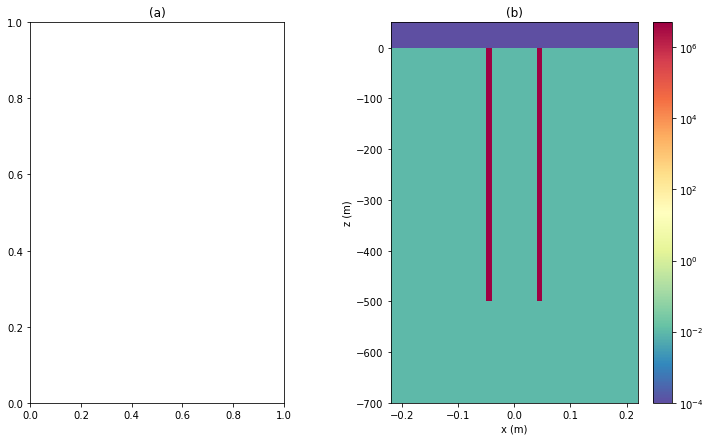

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [1, 1.22], "wspace":0.38})

# plot_geometry(ax[0])
plot_casing(ax[1], models["casing_200_1e-02"]["sigma"])

ax[0].set_title("(a)")
ax[1].set_title("(b)")

## set up the simulations

In [21]:
# top casing source 
src_theta = mesh.hy[0]/2.
src_a = np.r_[casing_b - mesh.hx.min()/2, src_theta, -csz/2]
src_b = np.r_[return_electrode_r, src_theta, -csz/2]
src_locations = np.vstack(
    [
        src_a, src_a+np.r_[0, 0, csz*1.5], src_b+np.r_[0, 0, csz*1.5], src_b
    ]
)
src_locations

/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1042: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(


array([[ 4.88442571e-02,  2.61799388e-01, -2.50000000e+00],
       [ 4.88442571e-02,  2.61799388e-01,  5.00000000e+00],
       [ 5.00000000e+02,  2.61799388e-01,  5.00000000e+00],
       [ 5.00000000e+02,  2.61799388e-01, -2.50000000e+00]])

In [22]:
def generate_simulation(mur, freq=None): 
    if freq is not None: 
        freqs = [freq]
    else:
        freqs = frequencies
    src_list = [
        fdem.sources.LineCurrent([], location=src_locations, frequency=f)
        for f in freqs
    ]
    survey = fdem.Survey(src_list)
    sim = fdem.simulation.Simulation3DCurrentDensity(
        mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
        survey=survey, solver=Pardiso, mu=mur*mu_0,
        verbose=True
    )
    return sim

In [54]:
def load_fields(name, conductivity, mur):
    sim = generate_simulation(mur)
    sim.model = conductivity
    f = sim.fieldsPair(sim)
    for i, freq in enumerate(frequencies): 
        filename = f"{directory}/fields_{name}_{freq}.npy"
        if not os.path.exists(filename): 
            run_simulation(name)
        solution = np.load(filename)
        src = sim.survey.source_list[i]
        f[src, sim._solutionType] = solution
    return f

In [79]:
if run_simulations: 
    mesh.save(f"{directory}/mesh.json")
    np.save(f"{directory}/frequencies", frequencies)
    with open(f"{directory}/models.pkl", "wb") as fp:
        pickle.dump(models, fp)

In [57]:
def run_simulation(key):
    for freq in frequencies: 
        t = time.time()
        filename = f"{directory}/fields_{key}_{freq}.npy"
        if os.path.exists(filename):
            pass
        else: 
            print(f"starting {key}, {freq} Hz")
            sim = generate_simulation(models[key]["mur"], freq)
            f = sim.fields(models[key]["sigma"])
            np.save(f"{directory}/fields_{key}_{freq}", f[:, f"{sim._solutionType}"])
            print(f" ... done {key} {freq}. {time.time()-t:1.2e} s\n")
    return 

In [34]:
src_locations[-1,:]

array([ 5.00000000e+02,  2.61799388e-01, -2.50000000e+00])

In [69]:
def generate_dc_simulation(): 
    src_list = [
        dc.sources.Dipole([], location_a=src_locations[0,:], location_b=src_locations[-1,:])
    ]
        
    survey = dc.Survey(src_list)
    sim = dc.simulation.Simulation3DCellCentered(
        mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
        survey=survey, solver=Pardiso, bc_type="Dirichlet",
    #     verbose=True
    )
    return sim

In [70]:
def load_dc_fields(name, conductivity):
    solution = np.load(f"{directory}/fields_dc_{name}.npy")
    sim = generate_dc_simulation()
    sim.model = conductivity
    f = sim.fieldsPair(sim)
    f[:, "phiSolution"] = solution
    return f

In [71]:
def run_dc_simulation(key):
    t = time.time()
    filename = f"{directory}/fields_dc_{key}.npy"
    if os.path.exists(filename):
        pass
    else:
        print(f"starting {key}\n")
        sim = generate_dc_simulation()
        f = sim.fields(models[key]["sigma"])
        np.save(f"{directory}/fields_dc_{key}", f[:, f"phi"])
        print(f" ... done {key}. {time.time()-t:1.2e} s\n")
    return

In [26]:
# if run_simulations: 
#     for key in models.keys():
#         run_simulation(key)

In [27]:
# run_simulation(list(models.keys())[0])

starting halfspace_1e-02, 0.1 Hz



/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.area has been deprecated, please use CylindricalMesh.face_areas. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.vol has been deprecated, please use CylindricalMesh.cell_volumes. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


 ... done halfspace_1e-02 0.1. 2.25e+01 s
starting halfspace_1e-02, 0.15 Hz

 ... done halfspace_1e-02 0.15. 2.20e+01 s
starting halfspace_1e-02, 0.22 Hz

 ... done halfspace_1e-02 0.22. 2.15e+01 s
starting halfspace_1e-02, 0.32 Hz

 ... done halfspace_1e-02 0.32. 2.06e+01 s
starting halfspace_1e-02, 0.46 Hz

 ... done halfspace_1e-02 0.46. 2.21e+01 s
starting halfspace_1e-02, 0.68 Hz

 ... done halfspace_1e-02 0.68. 2.01e+01 s
starting halfspace_1e-02, 1.0 Hz

 ... done halfspace_1e-02 1.0. 2.20e+01 s
starting halfspace_1e-02, 1.5 Hz

 ... done halfspace_1e-02 1.5. 2.05e+01 s
starting halfspace_1e-02, 2.2 Hz

 ... done halfspace_1e-02 2.2. 1.94e+01 s
starting halfspace_1e-02, 3.2 Hz

 ... done halfspace_1e-02 3.2. 1.93e+01 s
starting halfspace_1e-02, 4.6 Hz

 ... done halfspace_1e-02 4.6. 2.02e+01 s
starting halfspace_1e-02, 6.8 Hz

 ... done halfspace_1e-02 6.8. 2.11e+01 s
starting halfspace_1e-02, 10.0 Hz

 ... done halfspace_1e-02 10.0. 1.95e+01 s
starting halfspace_1e-02, 15.0 Hz


In [61]:
# if run_simulations:   
#     with Pool(3) as p:
#         p.map(run_simulation, list(models.keys()))  

In [63]:
fields = {}
for key in models.keys():
    t = time.time()
    fields[key] = load_fields(key, models[key]["sigma"], models[key]["mur"])
    print(f"loaded {key}. {time.time()-t:1.2e}")

loaded halfspace_1e-02. 4.22e-01
loaded casing_1_1e-02. 3.61e-01
starting casing_50_1e-02, 0.46 Hz
 ... done casing_50_1e-02 0.46. 1.93e+01 s

starting casing_50_1e-02, 0.68 Hz
 ... done casing_50_1e-02 0.68. 2.13e+01 s

starting casing_50_1e-02, 1.0 Hz
 ... done casing_50_1e-02 1.0. 2.07e+01 s

starting casing_50_1e-02, 1.5 Hz
 ... done casing_50_1e-02 1.5. 2.00e+01 s

starting casing_50_1e-02, 2.2 Hz
 ... done casing_50_1e-02 2.2. 2.03e+01 s

starting casing_50_1e-02, 3.2 Hz
 ... done casing_50_1e-02 3.2. 2.03e+01 s

starting casing_50_1e-02, 4.6 Hz
 ... done casing_50_1e-02 4.6. 2.23e+01 s

starting casing_50_1e-02, 6.8 Hz
 ... done casing_50_1e-02 6.8. 2.21e+01 s

starting casing_50_1e-02, 10.0 Hz
 ... done casing_50_1e-02 10.0. 2.14e+01 s

starting casing_50_1e-02, 15.0 Hz
 ... done casing_50_1e-02 15.0. 2.14e+01 s

starting casing_50_1e-02, 22.0 Hz
 ... done casing_50_1e-02 22.0. 2.11e+01 s

starting casing_50_1e-02, 32.0 Hz
 ... done casing_50_1e-02 32.0. 2.23e+01 s

starting ca

In [64]:
models.keys()

dict_keys(['halfspace_1e-02', 'casing_1_1e-02', 'casing_50_1e-02', 'casing_100_1e-02', 'casing_150_1e-02', 'casing_200_1e-02', 'permeable_only_200_1e-02', 'permeable_only_5000000_1e-02', 'halfspace_1e-01', 'casing_1_1e-01', 'casing_50_1e-01', 'casing_100_1e-01', 'casing_150_1e-01', 'casing_200_1e-01', 'permeable_only_200_1e-01', 'permeable_only_5000000_1e-01', 'halfspace_1e+00', 'casing_1_1e+00', 'casing_50_1e+00', 'casing_100_1e+00', 'casing_150_1e+00', 'casing_200_1e+00', 'permeable_only_200_1e+00', 'permeable_only_5000000_1e+00'])

In [72]:
dc_keys = []

for k in models.keys():
    if "halfspace" in k:
        dc_keys.append(k)
    elif "casing" in k:
        if k.split("_")[1] == "1": 
            dc_keys.append(k)

dc_keys

['halfspace_1e-02',
 'casing_1_1e-02',
 'halfspace_1e-01',
 'casing_1_1e-01',
 'halfspace_1e+00',
 'casing_1_1e+00']

In [77]:
for k in dc_keys: 
    run_dc_simulation(k)

starting casing_1_1e-02

 ... done casing_1_1e-02. 1.48e+00 s

starting halfspace_1e-01

 ... done halfspace_1e-01. 1.43e+00 s

starting casing_1_1e-01

 ... done casing_1_1e-01. 1.42e+00 s

starting halfspace_1e+00

 ... done halfspace_1e+00. 1.42e+00 s

starting casing_1_1e+00

 ... done casing_1_1e+00. 1.57e+00 s



In [78]:
fields_dc = {}
for k in dc_keys:
    fields_dc[k] = load_dc_fields(k, models[k]["sigma"])

In [108]:
rcParams["font.size"] = 13

In [37]:
fields.keys()

dict_keys(['halfspace_1e-02'])

In [87]:
freq_inds_plot = np.r_[0, 3, 6, 9, 12, 15, 18]
frequencies[freq_inds_plot]

array([  0.1 ,   0.32,   1.  ,   3.2 ,  10.  ,  32.  , 100.  ])

In [276]:
fields_dc

{'halfspace_1e-02': <SimPEG.electromagnetics.static.resistivity.fields.Fields3DCellCentered at 0x7fe6b5c01880>,
 'casing_1_1e-02': <SimPEG.electromagnetics.static.resistivity.fields.Fields3DCellCentered at 0x7fe6b5d26790>,
 'halfspace_1e-01': <SimPEG.electromagnetics.static.resistivity.fields.Fields3DCellCentered at 0x7fe6b5bf8f40>,
 'casing_1_1e-01': <SimPEG.electromagnetics.static.resistivity.fields.Fields3DCellCentered at 0x7fe6b5bf86a0>,
 'halfspace_1e+00': <SimPEG.electromagnetics.static.resistivity.fields.Fields3DCellCentered at 0x7fe6b5bf80d0>,
 'casing_1_1e+00': <SimPEG.electromagnetics.static.resistivity.fields.Fields3DCellCentered at 0x7fe6b5c91430>}

/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1059: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:140: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: CylMesh.plotImage has been deprecated, please use CylMesh.plot_image. It will be removed in version 1.0.0

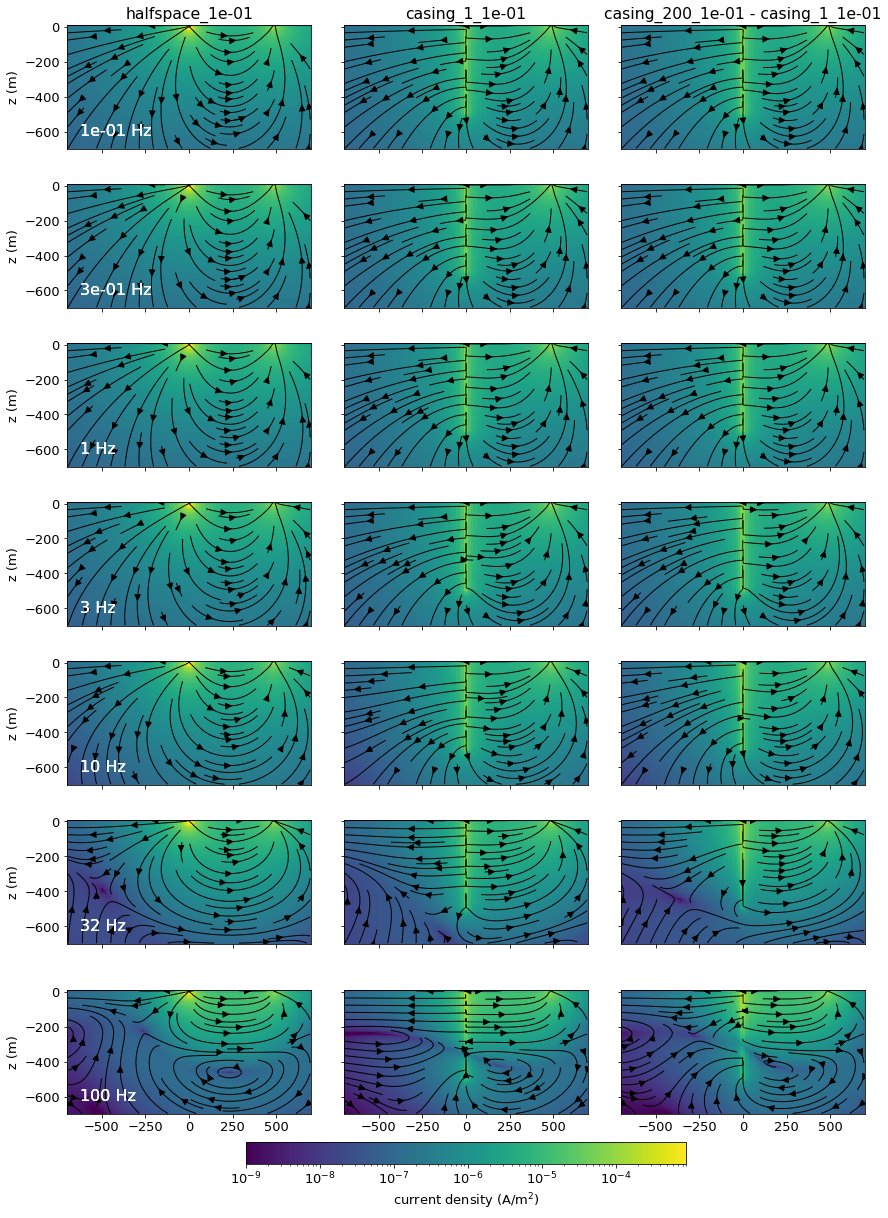

In [275]:
sigma_plot= 1e-1
mur_plot = np.r_[1, 100, 200]

plot_keys = [f"halfspace_{sigma_plot:1.0e}", f"casing_1_{sigma_plot:1.0e}", f"casing_200_{sigma_plot:1.0e}"]
primary_key = f"casing_1_{sigma_plot:1.0e}"
fig, ax = plt.subplots(
    len(freq_inds_plot), len(plot_keys), 
    figsize=(4*(len(plot_keys)), (len(freq_inds_plot))*2.4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

primary_fields = fields[primary_key]
reim = "real" 
xlim=700 * np.r_[-1, 1]
zlim=np.r_[-700, 10]
clim = np.r_[1e-9, 9e-4]

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}


for j, key in enumerate(plot_keys):
    f = fields[key]
    
    for i, freq in enumerate(frequencies[freq_inds_plot]):
        # if j == len(plot_keys) - 1:
        #     primsec = ["total", "secondary"]
        # else: 
        primsec = ["total"]
        
        for k, ps in enumerate(primsec): 
            out = casing_sim.view.plot_cross_section(
                f,
                view="j",
                xlim=xlim,
                zlim=zlim,
                theta_ind=0,
                ax=ax[i, j+k], 
                clim=clim,
                show_cb=False,
                stream_opts=stream_opts,
                real_or_imag=reim,
                src_ind=freq_inds_plot[i], 
                primary_fields=primary_fields,
                prim_sec=ps
            )
#         ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
            ax[i, j+k].set_title("")
            if i < len(frequencies)-1:
                ax[i, j+k].set_xlabel("")
            else:
                ax[i, j+k].set_xlabel("x (m)")
            if j > 0: 
                ax[i, j+k].set_ylabel("")
            else:
                ax[i, j+k].set_ylabel("z (m)")
            ax[i, j+k].set_aspect(1)
        if freq < 1: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{freq:1.0e} Hz", color="w", fontsize=16)
        else: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{freq:1.0f} Hz", color="w", fontsize=16)
        
    ax[0, j].set_title(key)
ax[0, -1].set_title(f"{key} - {primary_key}")
# ax[0, 0].set_title("(a)\nhalfspace")
# ax[0, 1].set_title("(b)\nconductive casing")
# ax[0, 2].set_title("(c)\nconductive, permeable casing")
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/fdem-cross-section-currents", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig(f"{fig_dir_low}/fdem-cross-section-currents", dpi=dpi_low, bbox_inches="tight")

In [111]:
def plot_cross_section_field(
    key, field, src_ind=0, theta_ind=3, ax=None, 
    xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 10],
    real_or_imag="real", 
    prime_sec="total", primary_fields=None, 
    primary_src_ind=None,
    log_scale=False, eps=1e-15, vmin=None, clim=None,
    component="both", show_colorbar=True,
    stream_opts=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

    mesh2d = casing_sim.utils.mesh2d_from_3d(mesh)

    if field in ["b", "h", "dbdt", "dhdt"]: 
        ave = mesh.average_edge_to_cell_vector
    elif field in ["e", "j"]:
        ave = mesh.average_face_to_cell_vector
    src = fields[key].survey.source_list[src_ind]    
    field_plot = ave * getattr(fields[key][src, field], real_or_imag)
    
    if prime_sec in ["secondary", "percent", "primary"]:
        if primary_src_ind is None: 
            primary_src_ind = src_ind
        primary_src = primary_fields.survey.source_list[primary_src_ind] 
        primary = ave * getattr(primary_fields[primary_src, field], real_or_imag)
        if prime_sec == "primary": 
            field_plot = primary
        else: 
            field_plot = field_plot - primary
            if prime_sec == "percent":
                field_plot = dfield_plot / np.abs(primary + eps) * 100

    
    components = ["x", "y", "z"]
    field_components = {}

    theta_ind_mirror = casing_sim.view.get_theta_ind_mirror(mesh, theta_ind)

    for i, comp in enumerate(components):
        fieldi = field_plot[i*mesh.n_cells:(i+1)*mesh.n_cells].reshape(
            mesh.vnC, order="F"
        )

        field_components[comp] = {
            "data":discretize.utils.mkvc(fieldi[:, theta_ind]),
            "mirror":(
                discretize.utils.mkvc(fieldi[:, theta_ind_mirror]) * 
                [-1 if comp=="y" else 1][0]
            ),
        }

    if component == "both" or component == "xz": 
        if component == "both":
            ax_xz = ax[0]
        else:
            ax_xz = ax
        # plot x,z vector
        fieldxz = np.hstack([field_components[c]["data"] for c in ["x", "z"]])
        fieldxz_mirror = np.hstack([field_components[c]["mirror"] for c in ["x", "z"]])

        sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]

        vmax = clim.max() if clim is not None else None
        if log_scale is True: 
            norm = LogNorm(vmin=vmin, vmax=vmax)
        else: 
            norm = Normalize(0, vmax)
        out = mesh2d.plot_image(
            fieldxz, v_type="CCv", view="vec", ax=ax_xz,
            range_x=xlim, range_y=zlim,
            sample_grid=sample_grid,
            mirror=True, mirror_data=fieldxz_mirror,
            pcolor_opts={"norm":norm},
            stream_threshold=vmin,
            stream_opts=stream_opts
        )
        if show_colorbar is True: 
            plt.colorbar(out[0], ax=ax_xz)


        pcolor_optsy = {"cmap":"Spectral_r"}
        linthresh = vmin if vmin is not None else eps

        if clim is None: 
            # vmin, vmax = np.max(np.abs(
            #     np.hstack([field_components[c]["data"] for c in ["x", "y", "z"]])
            # ))*np.r_[-1, 1]
            vmin, vmax = norm.vmax*np.r_[-1, 1]
        else: 
            vmin = np.min(clim)
            vmax = np.max(clim)

        if log_scale is True:
            pcolor_optsy["norm"] = SymLogNorm(vmin=vmin, vmax=vmax, linthresh=linthresh)
        else: 
            pcolor_optsy["norm"] = Normalize(vmin=vmin, vmax=vmax)
        
    if component == "both" or component == "y": 
        if component == "both":
            ax_y = ax[1]
        else: 
            ax_y = ax
        out2 = mesh2d.plot_image(
            field_components["y"]["data"], ax=ax_y,
            mirror=True, mirror_data=field_components["y"]["mirror"],
            range_x=xlim, range_y=zlim, 
            pcolor_opts=pcolor_optsy
        )
        if show_colorbar is True: 
            plt.colorbar(out2[0], ax=ax_y)
    return ax

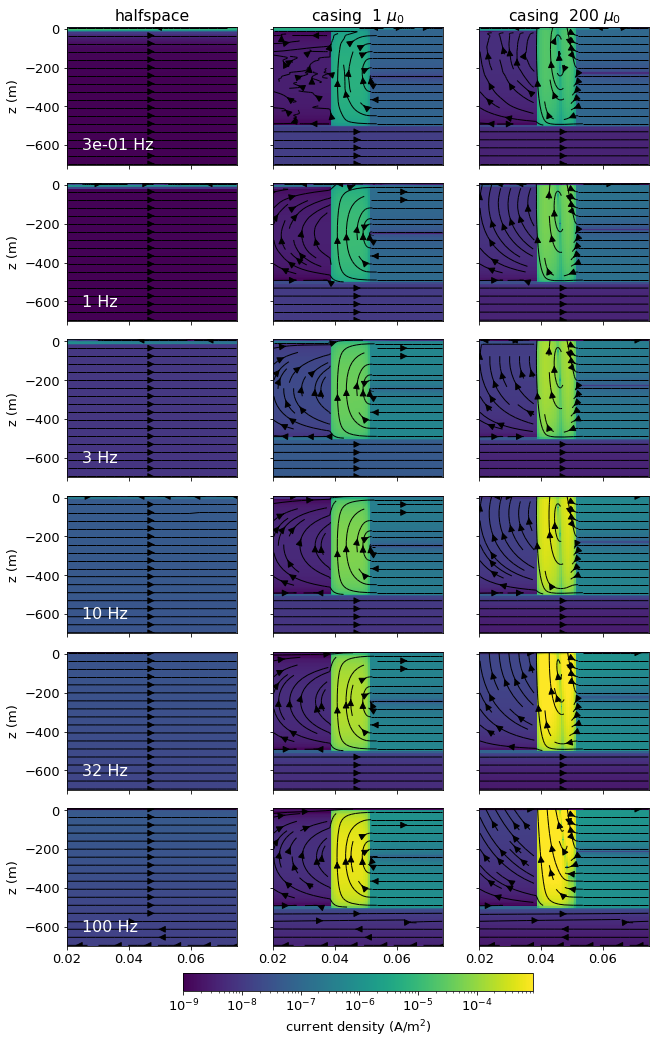

In [304]:
sigma_plot= 1e-1
mur_plot = np.r_[1, 100, 200]

# plot_key = f"halfspace_{sigma_plot:1.0e}"

plot_keys = [f"halfspace_{sigma_plot:1.0e}", f"casing_1_{sigma_plot:1.0e}", f"casing_200_{sigma_plot:1.0e}"]
primary_keys = [f"halfspace_{sigma_plot:1.0e}", f"casing_1_{sigma_plot:1.0e}", f"casing_1_{sigma_plot:1.0e}"]
stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}

fig, ax = plt.subplots(
    len(freq_inds_plot[1:]), len(plot_keys), 
    figsize=(3*len(plot_keys), (len(freq_inds_plot[1:]))*2.4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

reim = "real" 
xlim=np.r_[0.02, 0.075]
zlim=np.r_[-700, 10]
clim = np.r_[1e-7, 1e2]

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}



for i, freq in enumerate(frequencies[freq_inds_plot[1:]]):
    for j, key in enumerate(plot_keys): 
        plot_cross_section_field(
            key, "j", src_ind=freq_inds_plot[i], theta_ind=0, ax=ax[i, j], 
            xlim=xlim, zlim=zlim,
            real_or_imag="real", 
            prime_sec="secondary", 
            primary_fields=fields_dc[primary_keys[j]], 
            primary_src_ind=0,
            log_scale=True, eps=1e-15, vmin=None, clim=clim,
            component="xz",
            stream_opts=stream_opts,
            show_colorbar=False
        )

        ax[i, j].set_title("")
        
        if "casing" in key: 
            ax[0, j].set_title(f"{key.split('_')[0]}  {key.split('_')[1]} $\mu_0$")
        else: 
            ax[0, j].set_title(f"{key.split('_')[0]}")
        
        if i < len(frequencies)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        # ax[i, j].set_aspect(1)
        
    if freq < 1: 
        ax[i, 0].text(xlim.min()+0.005, zlim.min()+75, f"{freq:1.0e} Hz", color="w", fontsize=16)
    else: 
        ax[i, 0].text(xlim.min()+0.005, zlim.min()+75, f"{freq:1.0f} Hz", color="w", fontsize=16)
        
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/fdem-cross-section-currents", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig(f"{fig_dir_low}/fdem-cross-section-currents", dpi=dpi_low, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    3, len(frequencies),
    figsize=(len(frequencies)*2.2, 15),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.09,"wspace":0.05}
)

sigma_plot = 1e-1
mur_plot = np.r_[1, 200]
xlim= 0.075 * np.r_[-1, 1]
zlim=np.r_[-575, 5]
clim = np.r_[2e-5, 3e2]

stream_opts={"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}

primary_key = f"casing_1_{sigma_plot:1.0e}"

for i, key in enumerate([f"casing_{mur}_{sigma_plot:1.0e}" for mur in mur_plot]):
    f = fields[key]
    
    if i == 1:
        primsec = ["total", "secondary"]
    else: 
        primsec = ["total"]
    
    for j, freq in enumerate(frequencies): 
        for k, ps in enumerate(primsec): 
            out = casing_sim.view.plot_cross_section(
                f,
                view="j",
                xlim=xlim,
                zlim=zlim,
                theta_ind=0,
                ax=ax[i+k, j], 
                clim=clim,
                show_cb=False,
                stream_opts=stream_opts,
                real_or_imag="imag",
                src_ind=j, 
                prim_sec=ps, 
                primary_fields=fields[primary_key]
            )
            if i == 0:
                ax[i+k, j].set_xlabel("")
            else:
                ax[i+k, j].set_xlabel("x (m)")

                ax[i+k, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
                ax[i+k, j].set_title("")
        
        if freq < 1: 
            ax[0, j].text(0.07, -550, f"{freq:1.0e} Hz", color="w", fontsize=16, ha="right")
        else:
            ax[0, j].text(0.07, -550, f"{freq:1.0f} Hz", color="w", fontsize=16, ha="right")
        
        
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_xlim([0.02, 0.075])
        # ax[i, j].set_aspect(1)
    # ax[0, j].set_title(key)

cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("current density (A/m$^2$)")

# ax[0, 3].set_title("(a) conductive casing", fontsize=18, pad=8)
# ax[1, 3].set_title("(b) conductive, permeable casing", fontsize=18, pad=8)

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/tdem-casing-currents", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig(f"{fig_dir_low}/tdem-casing-currents", dpi=dpi_low, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    3, len(frequencies),
    figsize=(len(frequencies)*2.2, 15),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.09,"wspace":0.05}
)

sigma_plot = 1e-1
mur_plot = np.r_[1, 200]
xlim= 0.075 * np.r_[-1, 1]
zlim=np.r_[-575, 5]
clim = np.r_[2e-5, 3e2]

stream_opts={"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}

primary_key = f"casing_1_{sigma_plot:1.0e}"

for i, key in enumerate([f"casing_{mur}_{sigma_plot:1.0e}" for mur in mur_plot]):
    f = fields[key]
    
    if i == 1:
        primsec = ["total", "secondary"]
    else: 
        primsec = ["total"]
    
    for j, freq in enumerate(frequencies): 
        for k, ps in enumerate(primsec): 
            out = casing_sim.view.plot_cross_section(
                f,
                view="j",
                xlim=xlim,
                zlim=zlim,
                theta_ind=0,
                ax=ax[i+k, j], 
                clim=clim,
                show_cb=False,
                stream_opts=stream_opts,
                real_or_imag="imag",
                src_ind=j, 
                prim_sec=ps, 
                primary_fields=fields[primary_key]
            )
            if i == 0:
                ax[i+k, j].set_xlabel("")
            else:
                ax[i+k, j].set_xlabel("x (m)")

                ax[i+k, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
                ax[i+k, j].set_title("")
        
        if freq < 1: 
            ax[0, j].text(0.07, -550, f"{freq:1.0e} Hz", color="w", fontsize=16, ha="right")
        else:
            ax[0, j].text(0.07, -550, f"{freq:1.0f} Hz", color="w", fontsize=16, ha="right")
        
        
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_xlim([0.02, 0.075])
        # ax[i, j].set_aspect(1)
    # ax[0, j].set_title(key)

cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("current density (A/m$^2$)")

# ax[0, 3].set_title("(a) conductive casing", fontsize=18, pad=8)
# ax[1, 3].set_title("(b) conductive, permeable casing", fontsize=18, pad=8)

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/tdem-casing-currents", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig(f"{fig_dir_low}/tdem-casing-currents", dpi=dpi_low, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(1, 1)
key = "casing_200"
primary_key = "casing_1"
f = fields[key]
xlim=600*np.r_[-1, 1]
src_ind=5
zind = 118
clim = np.r_[1e-13, 3e-10]
out = casing_sim.view.plot_depth_slice(
    f,
    view="b",
    primary_fields=fields[primary_key],
    prim_sec="secondary",
    src_ind=src_ind,
    xlim=xlim,
    ylim=xlim,
    z_ind=zind, 
    theta_shift=0.5*mesh.hy[0],
    ax=ax, 
    # clim=clim,
    # show_cb=False,
    k=30,
    component="vec",
    real_or_imag="real",
    # stream_opts=stream_opts
)

ax.set_aspect(1)

In [ ]:
fig, ax = plt.subplots(
    len(frequencies), 2, figsize=(12,4*len(frequencies)), sharex=True, sharey=True
)

key = "casing_200"
primary_key = "casing_1"

# key = "permeable_only_5000000"
# primary_key = "halfspace"

for i, fi in enumerate(frequencies):
    plot_cross_section_field(
        key, "j", src_ind=i, theta_ind=0, ax=ax[i,:], 
        xlim=500*np.r_[-1, 1], zlim=np.r_[-600, 50],
        primary_key=primary_key, 
        real_or_imag = "imag", 
        prime_sec="secondary", 
        log_scale=True,
        
        # clim=1e-3*np.r_[-1, 1],
        vmin=1e-9
    )
    ax[i, 0].set_title(f"t={fi:1.0e} Hz")
    ax[i, 0].set_aspect(1)
    ax[i, 1].set_aspect(1)

In [ ]:
fig, ax = plt.subplots(
    len(frequencies), 2, figsize=(12,4*len(frequencies)), sharex=True, sharey=True
)

key = "casing_200"
primary_key = "casing_1"

for i, fi in enumerate(frequencies):
    plot_cross_section_field(
        key, "e", src_ind=i, theta_ind=0, ax=ax[i,:], 
        xlim=500*np.r_[-1, 1], zlim=np.r_[-600, 50],
        primary_key=primary_key, 
        real_or_imag = "real", 
        prime_sec="secondary", 
        log_scale=True,
        # clim=1e-3*np.r_[-1, 1],
        vmin=1e-7
    )
    ax[i, 0].set_title(f"t={fi:1.0e} Hz")
    ax[i, 0].set_aspect(1)
    ax[i, 1].set_aspect(1)

In [ ]:
fig, ax = plt.subplots(
    len(frequencies), 2, figsize=(12,4*len(frequencies)), sharex=True, sharey=True
)

key = "casing_200"
primary_key = "casing_1"

for i, fi in enumerate(frequencies):
    plot_cross_section_field(
        key, "b", src_ind=i, theta_ind=3, ax=ax[i,:], 
        xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 10],
        primary_key=primary_key, 
        real_or_imag = "real", 
        prime_sec="secondary", 
        # log_scale=True,
        clim = 1e-10*np.r_[-1, 1],
        # vmin=1e-15
    )
    ax[i, 0].set_title(f"t={fi:1.0e} Hz")
    # ax[i, 0].set_aspect(1)
    # ax[i, 1].set_aspect(1)

plot data 

In [166]:
xlocs = np.r_[30, 57, 58, 60, 65, 75]
mesh.nodes_x[xlocs]

array([1.10146714e-01, 7.50000000e+01, 1.00000000e+02, 1.50000000e+02,
       2.75000000e+02, 5.25000000e+02])

In [167]:
zloc = -csz/2
theta_loc = 3

face_inds = np.zeros_like(xlocs)

for i, xl in enumerate(xlocs):
    face_inds[i] = np.where(
        (mesh.faces_x[:, 0] == mesh.vectorNx[xl]) &
        (mesh.faces_x[:, 1] == mesh.vectorCCy[theta_loc]) & 
        (np.abs(mesh.faces_x[:, 2] - zloc) == np.min(np.abs(mesh.faces_x[:, 2] - zloc)))
    )[0]
    print(mesh.faces_x[face_inds[i], :])

[ 0.11014671  1.83259571 -2.5       ]
[75.          1.83259571 -2.5       ]
[100.           1.83259571  -2.5       ]
[150.           1.83259571  -2.5       ]
[275.           1.83259571  -2.5       ]
[525.           1.83259571  -2.5       ]


In [168]:
def plot_pos_neg_log(x, y, ax, plot_type="semilogy", color=None, marker=None, label=None):
    if plot_type == "plot":
        return ax.plot(x, y, color=color, label=label)
    else:
        inds_pos = (y > 0)
        
        inds_switch = np.where(np.diff(inds_pos))[0].astype(int)+1
        starting_inds = np.hstack([np.r_[0], inds_switch])
        ending_inds = np.hstack([inds_switch, np.r_[len(inds_pos)]])
            
        for start, end in zip(starting_inds, ending_inds):
            xvals = x[start:end]
            yvals = y[start:end]
            if np.all(yvals <= 0):
                getattr(ax, plot_type)(xvals, np.abs(yvals), "--", marker=marker, color=color)
            else: 
                getattr(ax, plot_type)(xvals, yvals, "-", marker=marker, color=color, label=label)
                label=None
        return ax

In [169]:
def get_amplitude_phase(f):
    real = f.real
    imag = f.imag
    amplitude = np.sqrt(real**2 + imag**2)
    phase = 180/np.pi*np.arctan2(imag, real)
    return amplitude, phase

[100.           1.83259571  -2.5       ]


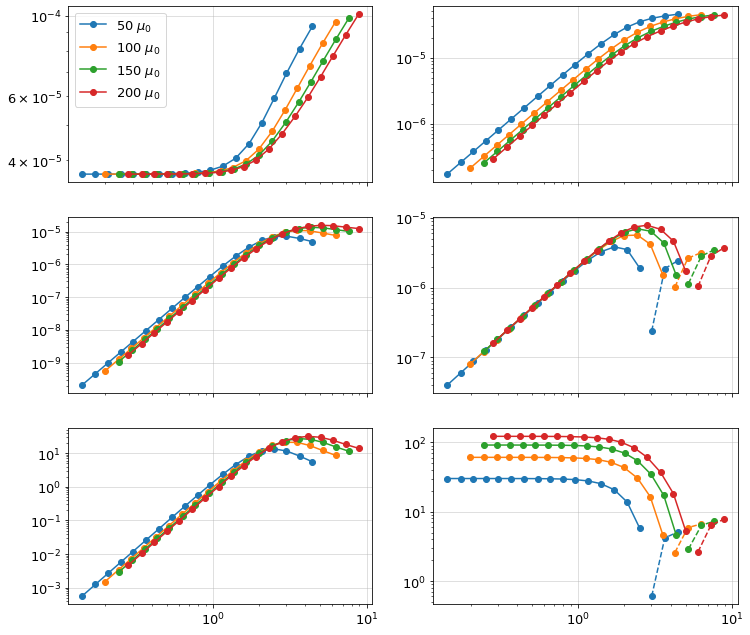

In [274]:
fi = 2
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

print(mesh.faces_x[face_inds[fi]])
sigma_plot = 1e-1
primary_key = f"casing_1_{sigma_plot:1.0e}"
mur_plot = mur_casing
primary = fields[primary_key][:, "e"][face_inds[fi]]

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

x = frequencies

for i, mur in enumerate(mur_casing):
    key = f"casing_{mur}_{sigma_plot:1.0e}"
    total = fields[key][:, "e"][face_inds[fi]]
    diff = total - primary
    
    # x = np.sqrt(sigma_casing * mur * mu_0 * 2 * np.pi * frequencies) * casing_t
    
    label = f"{mur} $\mu_0$"
    plot_pos_neg_log(x, total.real, ax[0, 0], plot_type="loglog", marker="o", color=f"C{i}", label=label)
    plot_pos_neg_log(x, total.imag, ax[0, 1], plot_type="loglog", marker="o", color=f"C{i}", label=label)
    plot_pos_neg_log(x, diff.real, ax[1, 0], plot_type="loglog", marker="o", color=f"C{i}", label=None)
    plot_pos_neg_log(x, diff.imag, ax[1, 1], plot_type="loglog", marker="o", color=f"C{i}", label=None)
    plot_pos_neg_log(x, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="loglog", marker="o", color=f"C{i}", label=None)
    plot_pos_neg_log(x, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="loglog", marker="o", color=f"C{i}", label=None)
    
for a in ax.flatten():
    a.grid("both", alpha=0.5)

# for a in ax[0, :].flatten():
#     a.set_ylim([1e-7, 2e-4])
    
# for a in ax[1, :].flatten():
#     a.set_ylim([1e-10, 3e-5])

# for a in ax[2, :].flatten():
#     a.set_ylim([1e-3, 2e2])
# for a in ax[1, :]:
#     a.set_ylim(1e-5*np.r_[-1, 2])
# for a in ax[:2, 0].flatten():
#     a.set_ylim(re_ylim)

# for a in ax[:2, 1].flatten():
#     a.set_ylim(im_ylim)
    
ax[0, 0].legend(loc=0)

In [171]:
mesh.faces_x[face_inds[fi], :]

array([75.        ,  1.83259571, -2.5       ])

Text(0.5, 1.0, 'Phase ($\\degree$)')

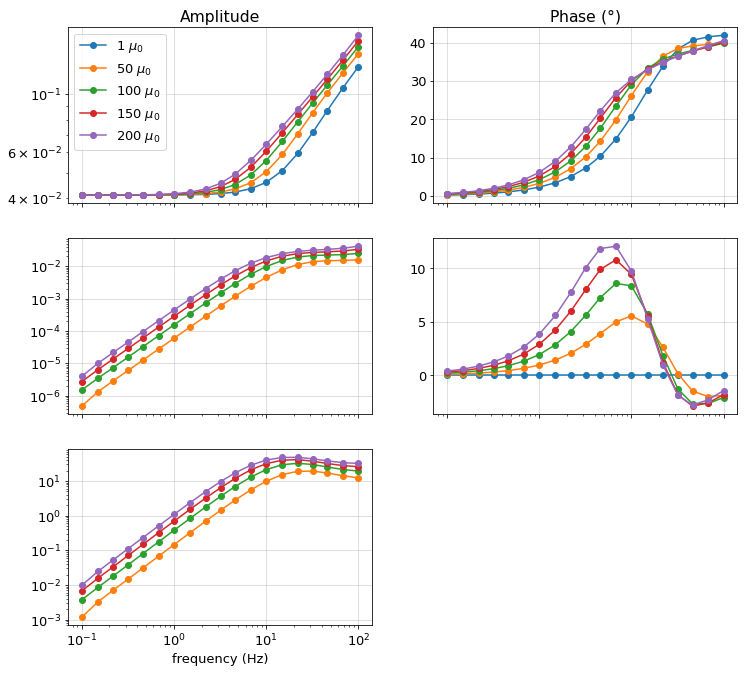

In [173]:
fi = 0
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

sigma_plot = 1e-1
primary_key = f"casing_1_{sigma_plot:1.0e}"
mur_plot = mur_casing
primary = fields[primary_key][:, "e"][face_inds[fi]]
a_primary, p_primary = get_amplitude_phase(primary)

for i, key in enumerate([f"casing_{mur}_{sigma_plot:1.0e}" for mur in mur_casing]):
    total = fields[key][:, "e"][face_inds[fi]]
    a_total, p_total = get_amplitude_phase(total)
    a_diff, p_diff = (a_total - a_primary), (p_total - p_primary)
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    ax[0, 0].loglog(frequencies, a_total, "-o", color=f"C{i}", label=label)
    ax[0, 1].semilogx(frequencies, p_total, "-o", color=f"C{i}", label=label)
    
    plot_pos_neg_log(frequencies, a_diff, ax[1, 0], plot_type="loglog", marker="o", color=f"C{i}", label=None)
    ax[1, 1].semilogx(frequencies, p_diff, marker="o", color=f"C{i}", label=None)
    
    plot_pos_neg_log(frequencies, a_diff/a_primary*100, ax[2, 0], plot_type="loglog", marker="o", color=f"C{i}", label=None)
    
for a in ax.flatten():
    a.grid("both", alpha=0.5)

for a in ax.flatten():
    a.grid("both", alpha=0.5)
# for a in ax[0, :].flatten():
#     a.set_ylim([1e-7, 2e-4])
    
# for a in ax[1, :].flatten():
#     a.set_ylim([1e-10, 3e-5])

# for a in ax[2, :].flatten():
#     a.set_ylim([1e-3, 2e2])
# for a in ax[1, :]:
#     a.set_ylim(1e-5*np.r_[-1, 2])
# for a in ax[:2, 0].flatten():
#     a.set_ylim(re_ylim)

# for a in ax[:2, 1].flatten():
#     a.set_ylim(im_ylim)
    
ax[0, 0].legend(loc=0)
ax[2, 1].axis("off")
ax[2, 0].set_xlabel("frequency (Hz)")

ax[0, 0].set_title("Amplitude")
ax[0, 1].set_title("Phase ($\degree$)")

In [287]:
theta_loc = 6
faces_perpendicular = np.where(
    (mesh.faces_x[:, 1] == mesh.vectorCCy[theta_loc]) & 
    (np.abs(mesh.faces_x[:, 2] - zloc) == np.min(np.abs(mesh.faces_x[:, 2] - zloc)))
)[0]


In [288]:
frequencies[10]

4.6

4.6


Text(0.5, 0, 'distance (m)')

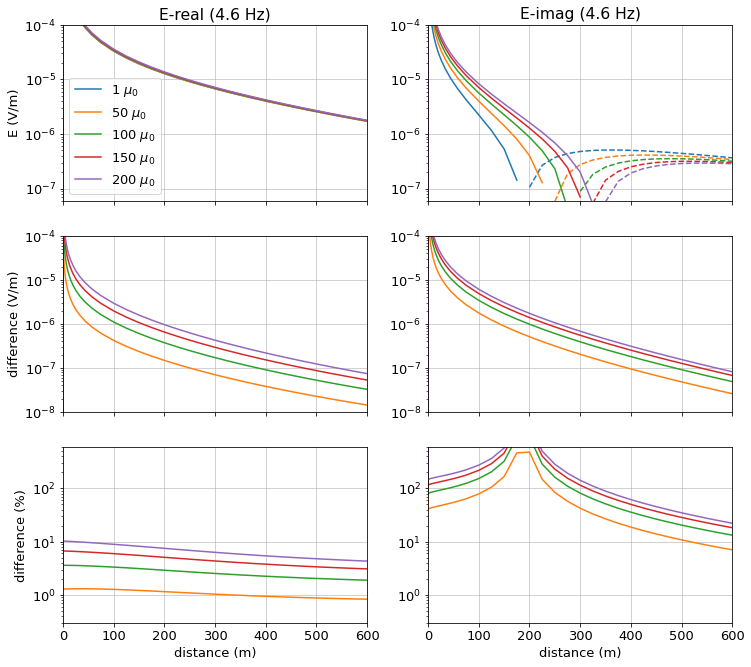

In [289]:
src_ind = 10
print(frequencies[src_ind])

sigma_plot = 1e-1
mur_plot = mur_casing

fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)
primary_key = f"casing_1_{sigma_plot:1.0e}"

primary_src = fields[primary_key].survey.source_list[src_ind]
primary = fields[primary_key][primary_src, "e"][faces_perpendicular].squeeze()

for i, key in enumerate([f"casing_{mur}_{sigma_plot:1.0e}" for mur in mur_plot]):
    src = fields[key].survey.source_list[src_ind]
    total = fields[key][src, "e"][faces_perpendicular].squeeze()
    diff = total - primary
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    
    plot_pos_neg_log(mesh.nodes_x[1:], total.real, ax[0, 0], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.nodes_x[1:], total.imag, ax[0, 1], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.nodes_x[1:], diff.real, ax[1, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x[1:], diff.imag, ax[1, 1], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x[1:], diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x[1:], diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="semilogy", color=f"C{i}")
 
ax[0, 0].set_xlim([0, 600])
ax[0, 0].legend()

for a in ax.flatten():
    a.grid("both", alpha=0.7)

for a in ax[0, :].flatten():
    a.set_ylim([6e-8, 1e-4])
    
for a in ax[1, :].flatten():
    a.set_ylim([1e-8, 1e-4])

for a in ax[2, :].flatten():
    a.set_ylim([3e-1, 6e2])

ax[0, 0].set_title(f"E-real ({frequencies[src_ind]} Hz)")
ax[0, 1].set_title(f"E-imag ({frequencies[src_ind]} Hz)")

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")

ax[2, 0].set_xlabel("distance (m)")
ax[2, 1].set_xlabel("distance (m)")

In [298]:
def get_amplitude_phase(f):
    real = f.real
    imag = f.imag
    amplitude = np.sqrt(real**2 + imag**2)
    phase = 180/np.pi*np.arctan2(imag, real)
    return amplitude, phase

In [299]:
primary.shape

(90,)

4.6


Text(0.5, 0, 'distance (m)')

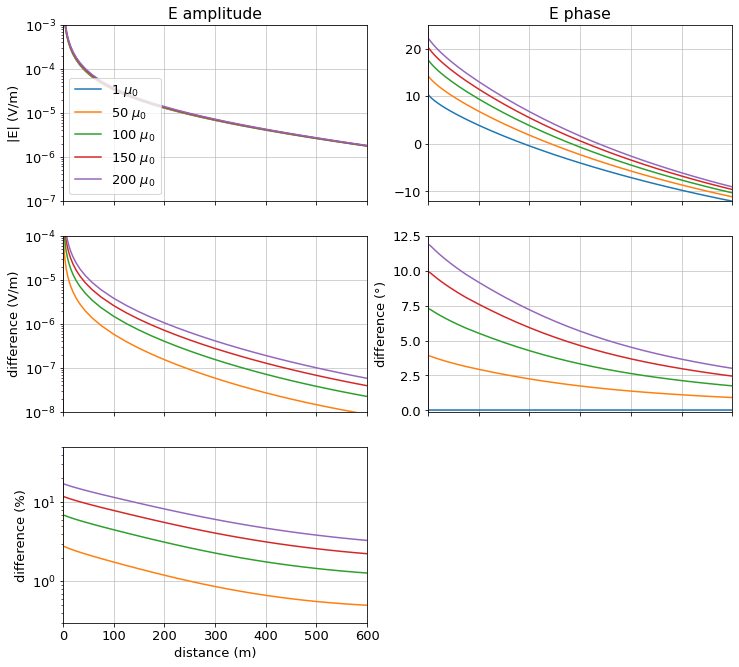

In [300]:
src_ind = 10
print(frequencies[src_ind])

sigma_plot = 1e-1
mur_plot = mur_casing

fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)
primary_key = f"casing_1_{sigma_plot:1.0e}"

primary_src = fields[primary_key].survey.source_list[src_ind]
primary = fields[primary_key][primary_src, "e"][faces_perpendicular].squeeze()
a_primary, p_primary = get_amplitude_phase(primary) 

xlim = [0, 600]
for i, key in enumerate([f"casing_{mur}_{sigma_plot:1.0e}" for mur in mur_plot]):
    src = fields[key].survey.source_list[src_ind]
    total = fields[key][src, "e"][faces_perpendicular].squeeze()
    diff = total - primary
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    
    a_total, p_total = get_amplitude_phase(total) 
    
    a_diff = a_total - a_primary
    p_diff = p_total - p_primary
    
    ax[0, 0].semilogy(mesh.nodes_x[1:], a_total, color=f"C{i}", label=label)
    ax[0, 1].plot(mesh.nodes_x[1:], p_total, color=f"C{i}", label=label)
    
    plot_pos_neg_log(mesh.nodes_x[1:], a_diff, ax[1, 0], plot_type="semilogy", color=f"C{i}", label=None)
    ax[1, 1].plot(mesh.nodes_x[1:], p_diff, color=f"C{i}", label=None)
    
    plot_pos_neg_log(mesh.nodes_x[1:], a_diff/a_primary*100, ax[2, 0], plot_type="semilogy", color=f"C{i}", label=None)

ax[0, 0].set_xlim(np.r_[0, 600])
for a in ax.flatten():
    a.grid("both", alpha=0.7)

ax[2, 1].axis("off")

ax[0, 0].set_title("E amplitude")
ax[0, 1].set_title("E phase")
# fig.suptitle(f"x={mesh.faces_x[face_ind, 0]}m, $\mu_r$={mur_plot:1.0f}", y=0.93)

ax[0, 0].set_ylabel("|E| (V/m)")
# ax[0, 1].set_ylabel("phase(E) ($\degree$)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[1, 1].set_ylabel("difference ($\degree$)")
ax[2, 0].set_ylabel("difference (%)")

# ax[0, 0].set_xlim()
ax[0, 0].legend()

ax[0, 0].set_ylim(1e-7, 1e-3)
ax[0, 1].set_ylim(-12, 25)
ax[1, 0].set_ylim(1e-8, 1e-4)
ax[1, 1].set_ylim(-0.1, 12.5)
ax[2, 0].set_ylim(3e-1, 50)

ax[2, 0].set_xlabel("distance (m)")

# ax[1, 1].set_xticklabels(ax[2, 0].get_xticklabels())
# ax[1, 1].set_xticks(ax[1, 1].get_xticks())



In [293]:
xlocs

array([55, 60, 75])

In [294]:
zloc = 0
theta_loc = 3

edge_inds = np.zeros_like(xlocs)

for i, xl in enumerate(xlocs):
    edge_inds[i] = np.where(
        (mesh.edges_y[:, 0] == mesh.vectorNx[xl]) &
        (mesh.edges_y[:, 1] == mesh.vectorCCy[theta_loc]) & 
        (np.abs(mesh.edges_y[:, 2] - zloc) == np.min(np.abs(mesh.edges_y[:, 2] - zloc)))
    )[0]
    print(mesh.edges_y[edge_inds[i], :])

[4.43980080e+01 1.83259571e+00 2.84217094e-13]
[1.50000000e+02 1.83259571e+00 2.84217094e-13]
[5.25000000e+02 1.83259571e+00 2.84217094e-13]


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.vectorNx has been deprecated, please use CylindricalMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


In [295]:
zloc = 0
theta_loc = 6

edges_perpendicular = np.where(
    # (mesh.edges_y[:, 0] == mesh.vectorNx[xl]) &
    (mesh.edges_y[:, 1] == mesh.vectorCCy[theta_loc]) & 
    (np.abs(mesh.edges_y[:, 2] - zloc) == np.min(np.abs(mesh.edges_y[:, 2] - zloc)))
)[0] + mesh.n_edges_x

100.0


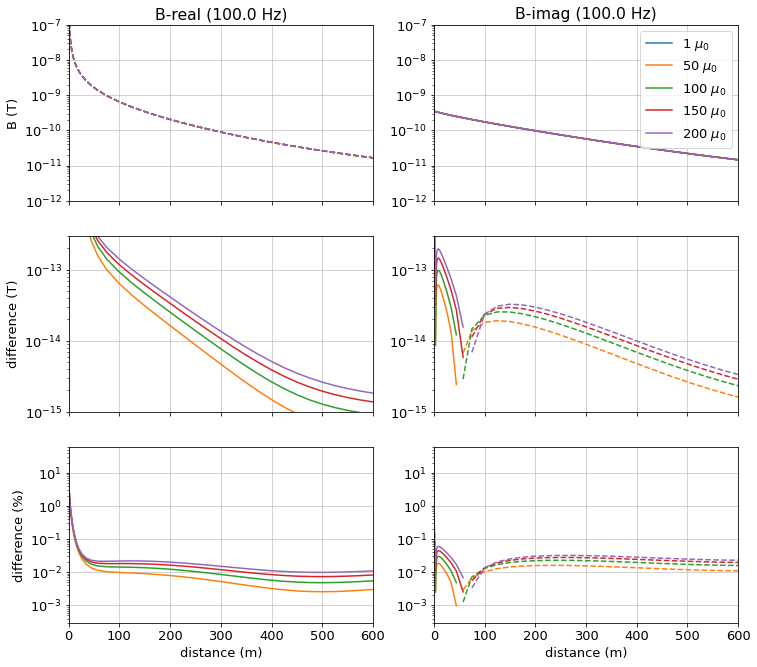

In [267]:
src_ind = 18
print(frequencies[src_ind])

sigma_plot = 1e-1
mur_plot = mur_casing

fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)
primary_key = f"casing_1_{sigma_plot:1.0e}"

primary_src = fields[primary_key].survey.source_list[src_ind]
primary = fields[primary_key][primary_src, "b"][edges_perpendicular].squeeze()

for i, key in enumerate([f"casing_{mur}_{sigma_plot:1.0e}" for mur in mur_plot]):
    src = fields[key].survey.source_list[src_ind]
    total = fields[key][src, "b"][edges_perpendicular].squeeze()
    diff = total - primary
    
    label = f"{key.split('_')[1]} $\mu_0$"
    
    plot_pos_neg_log(mesh.nodes_x[1:], total.real, ax[0, 0], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.nodes_x[1:], total.imag, ax[0, 1], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.nodes_x[1:], diff.real, ax[1, 0], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.nodes_x[1:], diff.imag, ax[1, 1], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.nodes_x[1:], diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x[1:], diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="semilogy", color=f"C{i}")
 
ax[0, 0].set_xlim([0, 600])


for a in ax.flatten():
    a.grid("both", alpha=0.7)

for a in ax[0, :].flatten():
    a.set_ylim([1e-12, 1e-7])
    
for a in ax[1, :].flatten():
    a.set_ylim([1e-15, 3e-13])

for a in ax[2, :].flatten():
    a.set_ylim([3e-4, 6e1])

ax[0, 0].set_title(f"B-real ({frequencies[src_ind]} Hz)")
ax[0, 1].set_title(f"B-imag ({frequencies[src_ind]} Hz)")

ax[0, 0].set_ylabel("B (T)")
ax[1, 0].set_ylabel("difference (T)")
ax[2, 0].set_ylabel("difference (%)")

ax[2, 0].set_xlabel("distance (m)")
ax[2, 1].set_xlabel("distance (m)")

ax[0, 1].legend()

In [134]:
cell_centered_e = {}
cell_centered_b = {}

for key, val in fields.items():
    if key not in cell_centered_e.keys():
        cell_centered_e[key] = mesh.average_face_to_cell_vector * val[:, "e"]
        
for key, val in fields.items():
    if key not in cell_centered_b.keys():
        cell_centered_b[key] = mesh.average_edge_to_cell_vector * val[:, "b"]

In [220]:
xlocs = np.r_[55, 60, 75]
print(mesh.cell_centers_x[xlocs])

theta_loc = np.r_[6]
print(mesh.cell_centers_y[theta_loc])

zloc = np.r_[118]
print(mesh.cell_centers_z[zloc])

# cell_centers

[ 51.05061499 162.5        537.5       ]
[3.40339204]
[2.5]


In [226]:
cell_centered_b.keys()

dict_keys(['halfspace_1e-02', 'casing_1_1e-02', 'casing_50_1e-02', 'casing_100_1e-02', 'casing_150_1e-02', 'casing_200_1e-02', 'permeable_only_200_1e-02', 'permeable_only_5000000_1e-02', 'halfspace_1e-01', 'casing_1_1e-01', 'casing_50_1e-01', 'casing_100_1e-01', 'casing_150_1e-01', 'casing_200_1e-01', 'permeable_only_200_1e-01', 'permeable_only_5000000_1e-01', 'halfspace_1e+00', 'casing_1_1e+00', 'casing_50_1e+00', 'casing_100_1e+00', 'casing_150_1e+00', 'casing_200_1e+00', 'permeable_only_200_1e+00', 'permeable_only_5000000_1e+00'])

In [222]:
cell_centers_plot = np.where(
    (mesh.cell_centers[:, 1] == mesh.cell_centers_y[theta_loc])&
    (mesh.cell_centers[:, 2] == mesh.cell_centers_z[zloc])
)[0]

In [223]:
cell_centered_b[primary_key].shape

(450360, 19)

10.0


Text(0, 0.5, 'difference (%)')

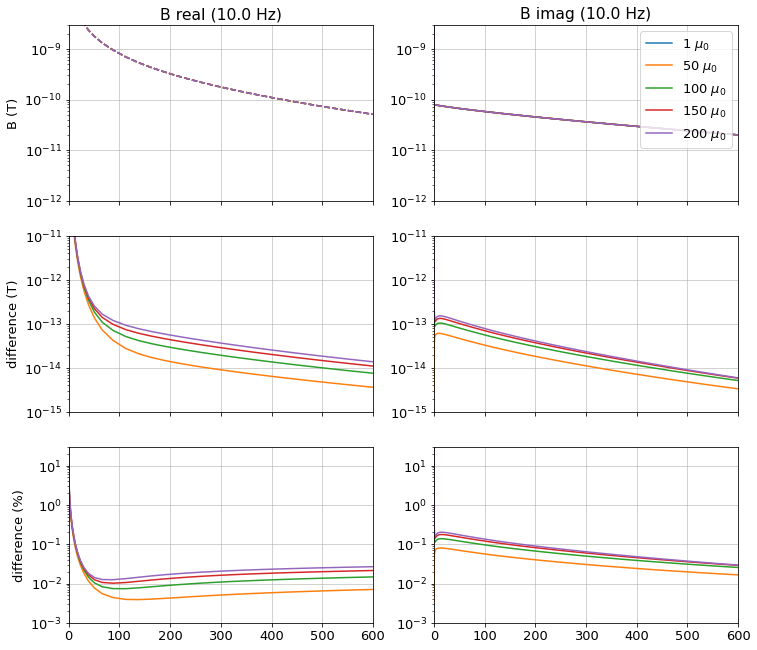

In [225]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

sigma_plot = 1e-1
freq_ind_plot = 12
print(frequencies[freq_ind_plot])

component = "y"

if component == "x":
    inds_plot = cell_centers_plot
elif component == "y":
    inds_plot = cell_centers_plot + mesh.n_cells
elif component == "z":
    inds_plot = cell_centers_plot + mesh.n_cells*2


primary_key = f"casing_1_{sigma_plot:1.0e}"

primary = cell_centered_b[primary_key][inds_plot, freq_ind_plot]

for i, key in enumerate([f"casing_{mur}_{sigma_plot:1.0e}" for mur in mur_casing]):
    
    total = cell_centered_b[key][inds_plot, freq_ind_plot]
    diff = total-primary
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    
    plot_pos_neg_log(mesh.cell_centers_x, total.real, ax[0, 0], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.cell_centers_x, total.imag, ax[0, 1], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.cell_centers_x, diff.real, ax[1, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.cell_centers_x, diff.imag, ax[1, 1], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.cell_centers_x, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.cell_centers_x, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="semilogy", color=f"C{i}")
 
ax[0, 0].set_xlim([0, 600])

for a in ax[0, :]: 
    a.set_ylim([1e-12, 3e-9])

for a in ax[1, :]:
    a.set_ylim([1e-15, 1e-11])

for a in ax[2, :]:
    a.set_ylim([1e-3, 3e1])

for a in ax.flatten():
    a.grid(alpha=0.7)
    
ax[0, 1].legend()
ax[0, 0].set_title(f"B real ({frequencies[freq_ind_plot]} Hz)")
ax[0, 1].set_title(f"B imag ({frequencies[freq_ind_plot]} Hz)")

ax[0, 0].set_ylabel("B (T)")
ax[1, 0].set_ylabel("difference (T)")
ax[2, 0].set_ylabel("difference (%)")